# Predicting Activity of Compounds for Drug Discovery

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Dataset Info

This bioassay dataset consists of 47831 training samples and 11957 test samples each having sparse feature vectors of size 154 and a target column showing the activity label of the compound. We can also see that the number of active compounds in our train data is 170 out of 47831 which is a very small ratio and therefore we need to balance our data while trainig the model. 

In [23]:
train_data = pd.read_csv('AID604red_train.csv')
test_data = pd.read_csv('AID604red_test.csv')

In [24]:
train_data.shape, test_data.shape

((47831, 155), (11957, 155))

In [26]:
np.sum(train_data['Outcome'] == 'Active')

170

In [ ]:
train_data.head()

,NEG_01_NEG,NEG_02_NEG,NEG_03_NEG,NEG_04_NEG,NEG_05_NEG,NEG_06_NEG,NEG_07_NEG,NEG_03_POS,NEG_04_POS,NEG_05_POS,NEG_06_POS,NEG_07_POS,NEG_01_HBD,NEG_02_HBD,NEG_03_HBD,NEG_04_HBD,NEG_05_HBD,NEG_06_HBD,NEG_07_HBD,NEG_03_HBA,NEG_04_HBA,NEG_05_HBA,NEG_06_HBA,NEG_07_HBA,NEG_02_ARC,NEG_03_ARC,NEG_04_ARC,NEG_05_ARC,NEG_06_ARC,NEG_07_ARC,NEG_02_HYP,NEG_03_HYP,NEG_04_HYP,NEG_05_HYP,NEG_06_HYP,NEG_07_HYP,POS_03_POS,POS_04_POS,POS_05_POS,POS_06_POS,...,HYP_01_HYP,HYP_02_HYP,HYP_03_HYP,HYP_04_HYP,HYP_05_HYP,HYP_06_HYP,HYP_07_HYP,WBN_GC_L_0.25,WBN_GC_H_0.25,WBN_GC_L_0.50,WBN_GC_H_0.50,WBN_GC_L_0.75,WBN_GC_H_0.75,WBN_GC_L_1.00,WBN_GC_H_1.00,WBN_EN_L_0.25,WBN_EN_H_0.25,WBN_EN_L_0.50,WBN_EN_H_0.50,WBN_EN_L_0.75,WBN_EN_H_0.75,WBN_EN_L_1.00,WBN_EN_H_1.00,WBN_LP_L_0.25,WBN_LP_H_0.25,WBN_LP_L_0.50,WBN_LP_H_0.50,WBN_LP_L_0.75,WBN_LP_H_0.75,WBN_LP_L_1.00,WBN_LP_H_1.00,XLogP,PSA,NumRot,NumHBA,NumHBD,MW,BBB,BadGroup,Outcome
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.40233,1.08841,-1.92506,2.04310,-2.73138,3.01521,-3.61565,3.99242,-0.898484,1.23575,-1.80292,2.09257,-2.70959,3.05102,-3.61732,4.02497,-0.845802,1.27313,-1.60690,2.25075,-2.49273,3.23219,-3.39496,4.21468,4.858,28.68,0,0,0,246.313,1,0,Active
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.37163,1.15488,-1.94285,2.02754,-2.77216,2.93499,-3.63394,3.85274,-0.848811,1.53930,-1.71658,2.37862,-2.59380,3.24926,-3.47696,4.13856,-1.081640,1.16984,-1.91518,2.06414,-2.77161,2.97303,-3.64178,3.88951,0.840,70.68,2,4,1,291.376,0,0,Active
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.35488,1.47647,-2.61217,2.24919,-2.99882,3.08114,-3.47268,3.93922,-0.669717,1.37016,-1.45272,2.18609,-2.26284,3.05479,-3.08245,3.93777,-0.917529,1.13269,-1.65268,1.99574,-2.44877,2.87862,-3.26270,3.76778,1.863,79.63,3,1,1,215.216,0,0,Active
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.46812,1.48042,-1.83631,1.97355,-2.44928,2.62998,-3.14394,3.37758,-0.754726,1.34417,-1.51691,2.01466,-2.28264,2.75596,-3.05044,3.52501,-0.850167,1.05359,-1.50911,1.82368,-2.21714,2.61147,-2.95973,3.40707,1.563,32.67,1,3,0,174.203,1,0,Active
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.39327,1.15471,-1.89540,2.03895,-2.57280,2.96278,-3.31886,3.89661,-0.841054,1.25148,-1.68737,2.07073,-2.53566,2.98474,-3.38491,3.91717,-0.847671,1.23367,-1.55695,2.16879,-2.36372,3.11003,-3.19637,4.05315,2.929,28.68,0,0,0,168.199,1,0,Active


In [ ]:
test_data.head()

,NEG_01_NEG,NEG_02_NEG,NEG_03_NEG,NEG_04_NEG,NEG_05_NEG,NEG_06_NEG,NEG_07_NEG,NEG_03_POS,NEG_04_POS,NEG_05_POS,NEG_06_POS,NEG_07_POS,NEG_01_HBD,NEG_02_HBD,NEG_03_HBD,NEG_04_HBD,NEG_05_HBD,NEG_06_HBD,NEG_07_HBD,NEG_03_HBA,NEG_04_HBA,NEG_05_HBA,NEG_06_HBA,NEG_07_HBA,NEG_02_ARC,NEG_03_ARC,NEG_04_ARC,NEG_05_ARC,NEG_06_ARC,NEG_07_ARC,NEG_02_HYP,NEG_03_HYP,NEG_04_HYP,NEG_05_HYP,NEG_06_HYP,NEG_07_HYP,POS_03_POS,POS_04_POS,POS_05_POS,POS_06_POS,...,HYP_01_HYP,HYP_02_HYP,HYP_03_HYP,HYP_04_HYP,HYP_05_HYP,HYP_06_HYP,HYP_07_HYP,WBN_GC_L_0.25,WBN_GC_H_0.25,WBN_GC_L_0.50,WBN_GC_H_0.50,WBN_GC_L_0.75,WBN_GC_H_0.75,WBN_GC_L_1.00,WBN_GC_H_1.00,WBN_EN_L_0.25,WBN_EN_H_0.25,WBN_EN_L_0.50,WBN_EN_H_0.50,WBN_EN_L_0.75,WBN_EN_H_0.75,WBN_EN_L_1.00,WBN_EN_H_1.00,WBN_LP_L_0.25,WBN_LP_H_0.25,WBN_LP_L_0.50,WBN_LP_H_0.50,WBN_LP_L_0.75,WBN_LP_H_0.75,WBN_LP_L_1.00,WBN_LP_H_1.00,XLogP,PSA,NumRot,NumHBA,NumHBD,MW,BBB,BadGroup,Outcome
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.42784,1.39995,-2.02457,2.20165,-2.71208,3.05703,-3.45730,3.93644,-0.757702,1.45270,-1.54289,2.24962,-2.35676,3.12269,-3.18367,4.01835,-0.920143,1.108960,-1.66595,1.99682,-2.47529,2.90260,-3.30230,3.81387,1.663,69.62,1,1,1,211.228,1,0,Active
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.79894,1.45884,-1.94757,2.23037,-2.54039,3.06172,-3.29666,3.91914,-0.670220,1.37075,-1.45466,2.18662,-2.26628,3.05475,-3.08741,3.93696,-0.916429,1.156470,-1.64960,2.00828,-2.44509,2.88808,-3.25929,3.77530,1.188,66.93,1,2,0,205.221,0,0,Active
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.37163,1.15438,-1.94217,2.02661,-2.77104,2.93357,-3.63253,3.85078,-0.848809,1.53902,-1.71656,2.37752,-2.59373,3.24715,-3.47683,4.13547,-1.092020,0.944368,-1.94458,1.85107,-2.82130,2.77023,-3.70884,3.69427,-0.912,70.15,2,5,1,291.376,0,0,Active
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.44538,1.68904,-1.99270,2.32601,-2.71978,3.11183,-3.52755,3.96196,-0.826680,1.46749,-1.67655,2.26948,-2.53536,3.13989,-3.39862,4.03395,-0.844968,1.164190,-1.61725,2.06286,-2.46200,2.97568,-3.32200,3.89328,3.253,50.68,1,1,0,225.251,1,0,Active
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-2.15168,1.79066,-2.29648,2.48068,-2.62344,3.34892,-3.17414,4.23416,-0.796108,1.51132,-1.62877,2.26744,-2.47121,3.11067,-3.31755,3.99027,-0.858186,0.992299,-1.67498,1.89483,-2.51920,2.80594,-3.36762,3.71921,0.949,120.62,6,6,1,293.235,0,0,Active


## Data Preparation

In order to preprocess the data, I have written a function which can apply normalization, dimensionality reduction with pca and resampling which is used for data balancing (augmenting the active clas so that the model captures both classes well). I have not used dimensionality reduction in any of the final models as it did not give a higher roc-auc score compared to the original feature size. 

In [2]:
def prepare_data(file_path, normalization=False, balance=False, dim_reduction=False):
    # reading data from csv to dataframe
    data = pd.read_csv(file_path)

    # balancing the data
    if balance:
        active = data[data.Outcome=='Active']
        inactive = data[data.Outcome=='Inactive']
        active_balanced = resample(active, replace=True, n_samples=len(inactive), random_state=27)
        data = pd.concat([active_balanced, inactive])
    
    # building x and y
    X = data.drop(['Outcome'], axis=1).to_numpy()
    y = data['Outcome']
    y = np.where(y.values == 'Active', 1, 0)

    # normalizaition
    if normalization:
        X = normalize(X)

    # dimensionality reduction
    if dim_reduction:
        pca = TruncatedSVD(n_components=20, random_state=42)
        X = pca.fit_transform(X)

    return X, y  

Below you can see the function which plots roc-curve.

In [3]:
def plot_roc_curve(y_test, y_preds):
    fpr, tpr, _ = roc_curve(y_test, y_preds)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## Classifiers

I have tested a Perceptron, Random Forest and Xgboost classifiers with hyperparameter tuning as needed and below you can see the roc-score and roc-curves of these models. I have choosed Perceptron with resampling as my final model due to its higher roc-score. 

 I have also applied dimensionality reduction with TruncatedSVD function on the data at early stages of implementing the classifiers but I couldn't achieve a higher roc-score so I omitted it in the final models below (dim-reduction flag is always false). 

### Perceptron

roc score =  0.8232879723437843


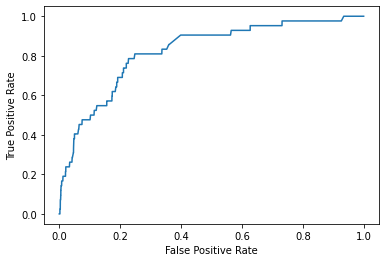

In [9]:
X_train, y_train = prepare_data('AID604red_train.csv', normalization=True, balance=True, dim_reduction=False)
X_test, y_test = prepare_data('AID604red_test.csv', normalization=True, balance=False, dim_reduction=False)

clf = Perceptron()
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
clf_isotonic.fit(X_train, y_train)
y_preds = clf_isotonic.predict_proba(X_test)
print("roc score = ", roc_auc_score(y_test, y_preds[:, 1]))
plot_roc_curve(y_test, y_preds[:, 1])

In [41]:
y_preds

array([[0.07814524, 0.92185476],
       [0.10393015, 0.89606985],
       [0.47857129, 0.52142871],
       ...,
       [0.84743328, 0.15256672],
       [0.86297946, 0.13702054],
       [0.37525815, 0.62474185]])

### Random Forest

In [21]:
# Hyper parameter Tuning
X_train, y_train = prepare_data('AID604red_train.csv', normalization=True, balance=False, dim_reduction=False)
X_test, y_test = prepare_data('AID604red_test.csv', normalization=True, balance=False, dim_reduction=False)

n_estimators = [200, 300, 400]
max_depth = [5, 6, 7]
params = {'n_estimators': n_estimators, 'max_depth': max_depth}

random_forest = RandomForestClassifier(class_weight = "balanced")
best_model = GridSearchCV(estimator = random_forest, param_grid = params, cv = 5, scoring='roc_auc')
best_model.fit(X_train, y_train)
print("Best params = ", best_model.best_params_)

Best params =  {'max_depth': 6, 'n_estimators': 400}


0.8103890654037528


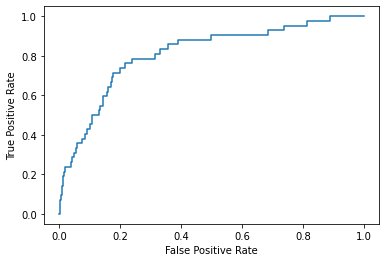

In [19]:
# Best params
X_train, y_train = prepare_data('AID604red_train.csv', normalization=True, balance=False, dim_reduction=False)
X_test, y_test = prepare_data('AID604red_test.csv', normalization=True, balance=False, dim_reduction=False)

clf = RandomForestClassifier(n_estimators = 400, max_depth = 6, class_weight = "balanced")
clf = clf.fit(X_train, y_train)
y_preds = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_preds[:, 1]))
plot_roc_curve(y_test, y_preds[:, 1])

### Xgboost

In [46]:
n_estimators = [100, 200, 300]
max_depth = [6, 7, 8, 9]

X_train, y_train = prepare_data('AID604red_train.csv', normalization=True, balance=False, dim_reduction=False)
X_test, y_test = prepare_data('AID604red_test.csv', normalization=True, balance=False, dim_reduction=False)

params = {'n_estimators': n_estimators, 
          'max_depth': max_depth}

best_model = xgboost.XGBClassifier()
best_model = GridSearchCV(estimator = best_model, param_grid = params, cv = 5, scoring='roc_auc')
best_model.fit(X_train, y_train)
print("Best params = ", best_model.best_params_)

Best params =  {'max_depth': 8, 'n_estimators': 200}


roc score =  0.8019812960853666


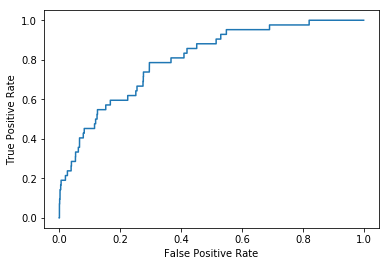

In [6]:
X_train, y_train = prepare_data('AID604red_train.csv', normalization=True, balance=False, dim_reduction=False)
X_test, y_test = prepare_data('AID604red_test.csv', normalization=True, balance=False, dim_reduction=False)

model = xgboost.XGBClassifier(max_depth = 8, n_estimators = 200, learning_rate = 0.1)
model.fit(X_train, y_train)
y_preds = model.predict_proba(X_test) 
print("roc score = ", roc_auc_score(y_test, y_preds[:, 1]))
plot_roc_curve(y_test, y_preds[:, 1])

In [38]:
y_preds

array([[8.97246268e-01, 1.02753732e-01],
       [9.62756066e-01, 3.72439335e-02],
       [9.94206967e-01, 5.79303334e-03],
       ...,
       [9.98905737e-01, 1.09426305e-03],
       [9.99080086e-01, 9.19913771e-04],
       [9.95700302e-01, 4.29969812e-03]])

## Training

In [49]:
# This function takes a csv file as input and returns a trained model as output
def train_assay(file_path):
    X_train, y_train = prepare_data(file_path, normalization=True, balance=True, dim_reduction=False)
    clf = Perceptron()
    clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
    clf_isotonic.fit(X_train, y_train)
    y_preds = clf_isotonic.predict_proba(X_test)
    return clf_isotonic

## Test

In [50]:
# This function takes a model and a test csv file as input and returns the predictions as output
def test_assay(model, file_path):
    X_test, _ = prepare_data(file_path, normalization=True, balance=False, dim_reduction=False)
    predicts = model.predict_proba(X_test) 
    return predicts

In [51]:
y_preds = test_assay(train_assay('AID604red_train.csv'), 'AID604red_test.csv')

In [52]:
print("roc score = ", roc_auc_score(y_test, y_preds[:, 1]))

roc score =  0.8232879723437843
